# Train Temporal Fusion Transformer predictor using PyTorch-Forecasting

In [1]:
# top-level requirements: pytorch-forecasting, ipykernel, jupyter, tensorboard
# install numba for improved speed

Following along with training example provided in docs - https://github.com/jdb78/pytorch-forecasting & https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
# imports for training
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss

## Set up data

In [4]:
# load training dataset from CSV
dataset_dir = os.path.join('data','example') # dataset directory
train_data = pd.read_csv(os.path.join(dataset_dir,'test','UCam_Building_5.csv'))
val_data = pd.read_csv(os.path.join(dataset_dir,'validate','UCam_Building_5.csv'))

In [5]:
def reformat_df(df):
    df = df.rename_axis('time_idx').reset_index() # create column of indices to pass as time_idx to TimeSeriesDataSet - we have no missing values
    df['ts_id'] = f'b{5}' # create column with ID of timeseries (use f'b{UCam building ID}')
    for col in ['Month','Hour','Day Type','Daylight Savings Status']:
        df[col] = df[col].astype(str) # convert to strs to use as categoric covariates
    return df

In [6]:
train_data, val_data = [reformat_df(df) for df in [train_data, val_data]]

In [7]:
train_data

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
0,0,12,24,1,0,NaN,NaN,NaN,70.0,0,0,0,0.0,b5
1,1,1,1,2,0,NaN,NaN,NaN,69.3,0,0,0,0.0,b5
2,2,1,2,2,0,NaN,NaN,NaN,69.3,0,0,0,0.0,b5
3,3,1,3,2,0,NaN,NaN,NaN,69.8,0,0,0,0.0,b5
4,4,1,4,2,0,NaN,NaN,NaN,69.4,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,12,19,3,0,NaN,NaN,NaN,65.0,0,0,0,0.0,b5
17516,17516,12,20,3,0,NaN,NaN,NaN,65.3,0,0,0,0.0,b5
17517,17517,12,21,3,0,NaN,NaN,NaN,60.6,0,0,0,0.0,b5
17518,17518,12,22,3,0,NaN,NaN,NaN,57.6,0,0,0,0.0,b5


In [8]:
val_data

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
0,0,12,24,5,0,NaN,NaN,NaN,83.5,0,0,0,0.0,b5
1,1,1,1,6,0,NaN,NaN,NaN,67.1,0,0,0,0.0,b5
2,2,1,2,6,0,NaN,NaN,NaN,67.9,0,0,0,0.0,b5
3,3,1,3,6,0,NaN,NaN,NaN,68.4,0,0,0,0.0,b5
4,4,1,4,6,0,NaN,NaN,NaN,67.2,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,17539,12,19,1,0,NaN,NaN,NaN,71.6,0,0,0,0.0,b5
17540,17540,12,20,1,0,NaN,NaN,NaN,70.1,0,0,0,0.0,b5
17541,17541,12,21,1,0,NaN,NaN,NaN,69.4,0,0,0,0.0,b5
17542,17542,12,22,1,0,NaN,NaN,NaN,69.1,0,0,0,0.0,b5


In [9]:
# construct training dataset
max_encoder_length = 48 # max number of previous instances to use for prediction
max_prediction_length = 24 # max forecasting horizon

training = TimeSeriesDataSet(
    train_data,
    time_idx= 'time_idx',  # column name of time of observation
    target= 'Equipment Electric Power [kWh]',  # column name of target to predict
    group_ids=['ts_id'],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID - ignore for the moment
    #static_categoricals=[ ... ],
    #static_reals=[ ... ],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=['Month','Hour','Day Type','Daylight Savings Status'],
    #time_varying_known_reals=[ ... ],
    #time_varying_unknown_categoricals=[ ... ],
    #time_varying_unknown_reals=[ ... ],
)

In [10]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, val_data)

In [11]:
# convert datasets to dataloaders for training
batch_size = 128
n_workers = 4
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=n_workers)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=n_workers)

## Train model

In [12]:
pl.seed_everything(42)

Global seed set to 42


42

### Tune hyper-parameters

In [13]:
hparam_trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    #log_interval=2,
    # set optimizer
    optimizer='adam',
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during chec

Number of parameters in network: 56.3k


/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Missing logger folder: /Users/max/Documents/PhD/Research/3 - Annex 37 CityLearn project/Annex_37/lightning_logs
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/max/Documents/PhD/Research/3 - Annex 37 CityLearn project/Annex_37/.lr_find_5f0eac90-be0b-4e61-a6ba-5f9764ac5fea.ckpt
Restored all states from the checkpoint file at /Users/max/Documents/PhD/Research/3 - Annex 37 CityLearn project/Annex_37/.lr_find_5f0eac90-be0b-4e61-a6ba-5f9764ac5fea.ckpt


Suggested learning rate: 0.001659586907437561


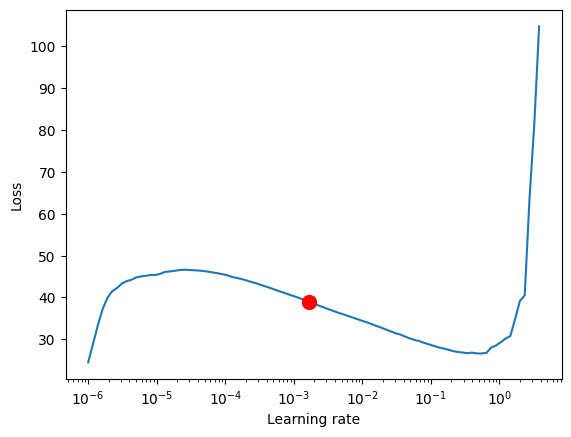

/var/folders/6t/69m7_zyd5_7crwy0sp1s3x100000gn/T/ipykernel_2153/1784886358.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [14]:
# find optimal learning rate
res = hparam_trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [15]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [16]:
# This is going to be a hefty hparam optimisation
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

### Perform training

In [42]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    #gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs", name="TFT-test")
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
# define network to train
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    #log_interval=2,
    # set optimizer
    optimizer='adam',
    # optimizer parameters
    learning_rate=res.suggestion(),
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 56.3k


/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [43]:
# fit the model on the data 
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 325   
3  | prescalers                         | ModuleDict                      | 0     
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 680   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 680   
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: 0it [00:00, ?it/s]

/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Evaluate trained model

In [44]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/max/opt/anaconda3/envs/Annex37/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [45]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
print((actuals - predictions).abs().mean())
print(val_data['Equipment Electric Power [kWh]'].abs().mean())

tensor(12.2342)
129.60791153670772


In [46]:
print(np.array(predictions[245]))

[108.75293  115.905075 137.32867  187.77216  205.4595   213.17113
 215.9931   214.93883  215.48962  215.24706  213.23036  208.32036
 203.11974  187.74147  164.26794  141.02174   89.45033   73.478096
  71.4649    70.4665    71.05062   70.90272   74.23091  106.69641 ]


In [47]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

In [69]:
help(TemporalFusionTransformer.plot_prediction)

Help on function plot_prediction in module pytorch_forecasting.models.temporal_fusion_transformer:

plot_prediction(self, x: Dict[str, torch.Tensor], out: Dict[str, torch.Tensor], idx: int, plot_attention: bool = True, add_loss_to_title: bool = False, show_future_observed: bool = True, ax=None, **kwargs) -> matplotlib.figure.Figure
    Plot actuals vs prediction and attention
    
    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on
    
    Returns:
        plt.Figure: matplotlib figure



In [68]:
print(raw_predictions.keys())
print(x.keys())

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')
dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


In [50]:
import matplotlib.pyplot as plt

In [63]:
print(tft.loss.compute())

tensor(8.3421)


See https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c for help with animations

/var/folders/6t/69m7_zyd5_7crwy0sp1s3x100000gn/T/ipykernel_2153/759424425.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


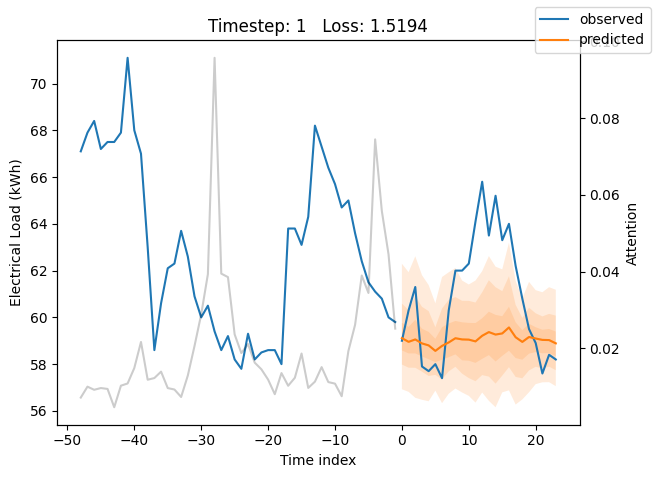

In [88]:

fig, main_ax = plt.subplots()
idx = 2
fig = tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True, ax=main_ax)
axs = fig.get_axes()
axs[0].set_ylabel('Electrical Load (kWh)')
prediction_loss = float(axs[0].get_title().split(' ')[1])
axs[0].set_title(f'Timestep: {idx}   Loss: {round(prediction_loss,4)}')
fig.show()

Try predicting on explicitly passed data as we will need to do for the forecasting

In [37]:
data_slice = val_data.iloc[1242:1314]
data_slice.iloc[-24:,data_slice.columns.get_loc('Equipment Electric Power [kWh]')] = 0
explicit_dataset = TimeSeriesDataSet.from_dataset(training, data_slice)

Note: because this model has known covariates over the prediction horizon, the explicit dataset we pass needs to have a length of `max_encoder_length`+`max_prediction_length`, but the target series values over the prediction horizons are (obviously) not used, so any values can be placed here (e.g. set to zero)

In [38]:
data_slice

,time_idx,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW],ts_id
1242,1242,2,18,1,0,NaN,NaN,NaN,73.9,0,0,0,0.0,b5
1243,1243,2,19,1,0,NaN,NaN,NaN,75.8,0,0,0,0.0,b5
1244,1244,2,20,1,0,NaN,NaN,NaN,74.1,0,0,0,0.0,b5
1245,1245,2,21,1,0,NaN,NaN,NaN,71.5,0,0,0,0.0,b5
1246,1246,2,22,1,0,NaN,NaN,NaN,71.8,0,0,0,0.0,b5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1309,2,13,4,0,NaN,NaN,NaN,0.0,0,0,0,689.0,b5
1310,1310,2,14,4,0,NaN,NaN,NaN,0.0,0,0,0,623.0,b5
1311,1311,2,15,4,0,NaN,NaN,NaN,0.0,0,0,0,505.0,b5
1312,1312,2,16,4,0,NaN,NaN,NaN,0.0,0,0,0,217.0,b5


In [39]:
slice_predictions = tft.predict(explicit_dataset, mode='prediction')

In [40]:
print(slice_predictions)

tensor([[194.4655, 178.9987, 161.4097,  88.0622,  64.8276,  66.0015,  62.1706,
          66.5997,  67.9521,  71.6635, 108.6616, 125.3289, 124.8316, 143.0763,
         199.7104, 224.3078, 234.1338, 234.9228, 233.2847, 233.6629, 235.8522,
         227.9212, 226.7105, 217.6792]])
